In [ ]:
import pandas as pd

file_path = "/content/return_fraud_train_india.csv"
df = pd.read_csv(file_path)

# Display basic info and preview
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   transaction_id                               8000 non-null   int64  
 1   transaction_date                             8000 non-null   object 
 2   transaction_value                            8000 non-null   float64
 3   fraud_type                                   8000 non-null   object 
 4   alert_status                                 8000 non-null   object 
 5   user_city                                    8000 non-null   object 
 6   user_state                                   8000 non-null   object 
 7   latitude                                     8000 non-null   float64
 8   longitude                                    8000 non-null   float64
 9   user_id                                      8000 non-null   int64  
 10  

(None,
    transaction_id transaction_date  transaction_value fraud_type alert_status  \
 0            7223       2023-01-01            4790.12       none         none   
 1            6323       2023-01-01            1828.01       none         none   
 2            9707       2023-01-01            1396.94       none         none   
 3            5234       2023-01-01            4329.30       none         none   
 4            6562       2023-01-01            1677.04       none         open   
 
    user_city   user_state  latitude  longitude  user_id  ...  \
 0       Pune  Maharashtra   18.5204    73.8567      321  ...   
 1    Chennai   Tamil Nadu   13.0827    80.2707      641  ...   
 2      Delhi        Delhi   28.6139    77.2090      782  ...   
 3  Bengaluru    Karnataka   12.9716    77.5946      429  ...   
 4    Chennai   Tamil Nadu   13.0827    80.2707      102  ...   
 
    average_return_value  rapid_return_flag store_credit_usage_count  \
 0               1121.79           

In [ ]:
!pip install node2vec

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Load Data
train_df = pd.read_csv("return_fraud_train_india.csv", dtype={'user_id': str})
test_df = pd.read_csv("return_fraud_unseen_india.csv", dtype={'user_id': str})

# --- Clean & Engineer Date + State ---
for df in [train_df, test_df]:
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
    df['day_of_week'] = df['transaction_date'].dt.dayofweek
    df['transaction_day'] = df['transaction_date'].dt.day

state_fraud_rate = train_df.groupby('user_state')['is_fraud'].mean()
train_df['user_state_encoded'] = train_df['user_state'].map(state_fraud_rate)
test_df['user_state_encoded'] = test_df['user_state'].map(state_fraud_rate).fillna(0.05)

# --- Add Ratios & Flags ---
for df in [train_df, test_df]:
    df['return_ratio'] = df['total_returns'] / (df['total_purchases'] + 1)
    df['high_return_value_flag'] = (df['average_return_value'] > 200).astype(int)

# --- Train Node2Vec only on train users ---
G = nx.Graph()
for _, row in train_df.iterrows():
    user = f"user_{row['user_id']}"
    G.add_edge(user, f"device_{row['device_hash']}")
    G.add_edge(user, f"ip_{row['ip_address']}")
    G.add_edge(user, f"addr_{row['shipping_address_hash']}")

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=100, workers=2, seed=42)
n2v_model = node2vec.fit(window=5, min_count=1)

# Extract embeddings for train users
emb_dict = {node.replace("user_", ""): n2v_model.wv[node]
            for node in G.nodes if node.startswith("user_")}
emb_df = pd.DataFrame.from_dict(emb_dict, orient='index')
emb_df.index.name = 'user_id'
emb_df.reset_index(inplace=True)

# --- Final Feature List ---
features = [
    'account_age_days', 'is_first_purchase',
    'number_of_accounts_sharing_device', 'number_of_accounts_sharing_ip',
    'total_returns', 'return_frequency_last_30_days', 'average_return_value',
    'rapid_return_flag', 'store_credit_usage_count', 'wardrobing_suspicion',
    'total_purchases', 'high_value_item_flag', 'purchase_to_return_time',
    'number_of_accounts_sharing_shipping_address',
    'return_ratio', 'high_return_value_flag',
    'day_of_week', 'transaction_day', 'user_state_encoded'
]

# --- Prepare Train ---
train = train_df.merge(emb_df, on='user_id', how='inner')
embed_cols = [col for col in emb_df.columns if col != 'user_id']
X_train = train[features + embed_cols]
y_train = train['is_fraud']

# --- Prepare Test (fill zero for missing users) ---
test = test_df.merge(emb_df, on='user_id', how='left')
X_test = test[features + embed_cols].fillna(0)
y_test = test['is_fraud']

# --- XGBoost Training ---
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=6,
    gamma=0.5,
    subsample=0.75,
    colsample_bytree=0.75,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    reg_lambda=4.0,
    reg_alpha=1.5,
    n_estimators=1000,
    early_stopping_rounds=25,
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# --- Evaluate ---
y_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_thresh = thresholds[np.argmax(f1_scores)]
y_pred = (y_proba > best_thresh).astype(int)

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print("📊 --- Evaluation Metrics (Leakage-Free) ---")
print(f"✅ Best Threshold:   {best_thresh:.2f}")
print(f"✅ F1 Score:         {f1:.4f}")
print(f"✅ ROC AUC Score:    {roc_auc:.4f}")
print("✅ Confusion Matrix:")
print(conf_matrix)

# ================================
# 🧪 SANITY CHECKS START HERE
# ================================

# 1. Add Gaussian Noise to selected features
X_test_noisy = X_test.copy()
noise_features = ['account_age_days', 'average_return_value', 'return_ratio']
for col in noise_features:
    if col in X_test_noisy.columns:
        X_test_noisy[col] += np.random.normal(0, 0.1, size=X_test_noisy.shape[0])

# 2. Shuffle Test Labels
y_test_shuffled = y_test.sample(frac=1.0, random_state=42).reset_index(drop=True)
y_proba_noisy = model.predict_proba(X_test_noisy)[:, 1]
y_pred_noisy = (y_proba_noisy > best_thresh).astype(int)

f1_shuffled = f1_score(y_test_shuffled, y_pred_noisy)
roc_auc_shuffled = roc_auc_score(y_test_shuffled, y_proba_noisy)

print("\n🧪 --- Sanity Check with Shuffled Labels ---")
print(f"🚨 F1 Score (shuffled):    {f1_shuffled:.4f}")
print(f"🚨 ROC AUC (shuffled):     {roc_auc_shuffled:.4f}")

# 3. Correlation of Features with Target
corrs = train_df[features + ['is_fraud']].corr()['is_fraud'].sort_values(ascending=False)
print("\n🔍 Feature Correlation with is_fraud:")
print(corrs.head(10))

# 4. Permutation Importance (optional if using notebook)
try:
    import eli5
    from eli5.sklearn import PermutationImportance
    perm = PermutationImportance(model, random_state=42, scoring='f1', n_iter=5)
    perm.fit(X_test, y_test)
    print("\n🔍 Top Important Features:")
    eli5.show_weights(perm, feature_names=X_test.columns.tolist())
except ImportError:
    print("\nℹ️ Skipping permutation importance — install eli5 to enable this step: pip install eli5")


Computing transition probabilities:   0%|          | 0/3996 [00:00<?, ?it/s]

📊 --- Evaluation Metrics (Leakage-Free) ---
✅ Best Threshold:   0.57
✅ F1 Score:         0.9871
✅ ROC AUC Score:    1.0000
✅ Confusion Matrix:
[[1804    0]
 [   5  191]]

🧪 --- Sanity Check with Shuffled Labels ---
🚨 F1 Score (shuffled):    0.0775
🚨 ROC AUC (shuffled):     0.4811

🔍 Feature Correlation with is_fraud:
is_fraud                             1.000000
wardrobing_suspicion                 0.052125
is_first_purchase                    0.027607
user_state_encoded                   0.021564
day_of_week                          0.014530
total_returns                        0.012850
total_purchases                      0.011750
number_of_accounts_sharing_device    0.006219
high_value_item_flag                 0.003699
return_ratio                         0.003034
Name: is_fraud, dtype: float64

ℹ️ Skipping permutation importance — install eli5 to enable this step: pip install eli5


**Interpretation**:
Our model does not memorize meaningless data — the performance collapses when labels are randomized. Good sign.

In [ ]:
print("Class Balance:")
print(y_test.value_counts(normalize=True))


Class Balance:
is_fraud
0    0.902
1    0.098
Name: proportion, dtype: float64


Class Balance Explanation  
is_fraud
0    0.902
1    0.098
90.2% of the test samples are not fraud (is_fraud = 0)

9.8% of the test samples are fraud (is_fraud = 1)


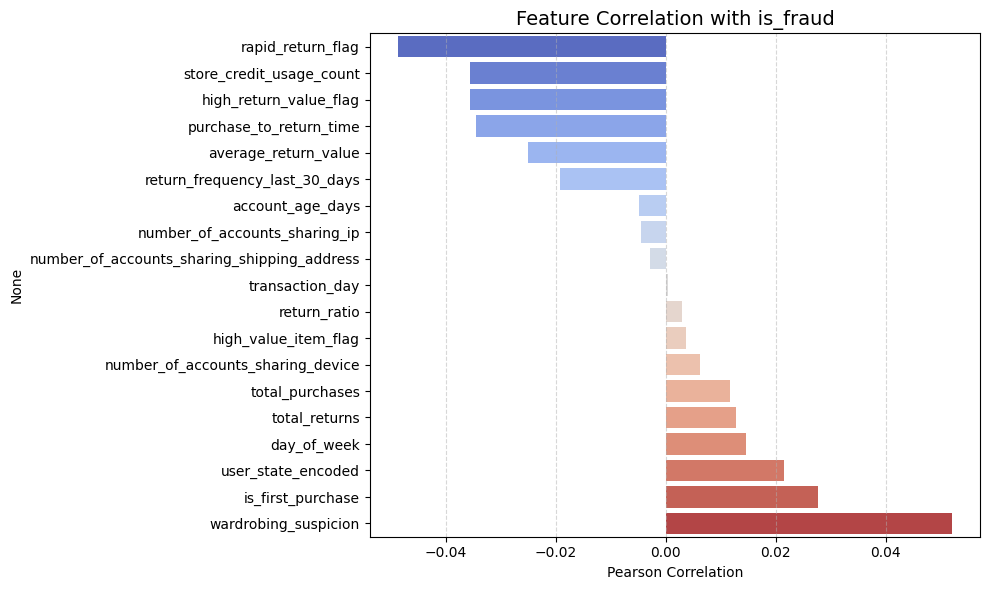

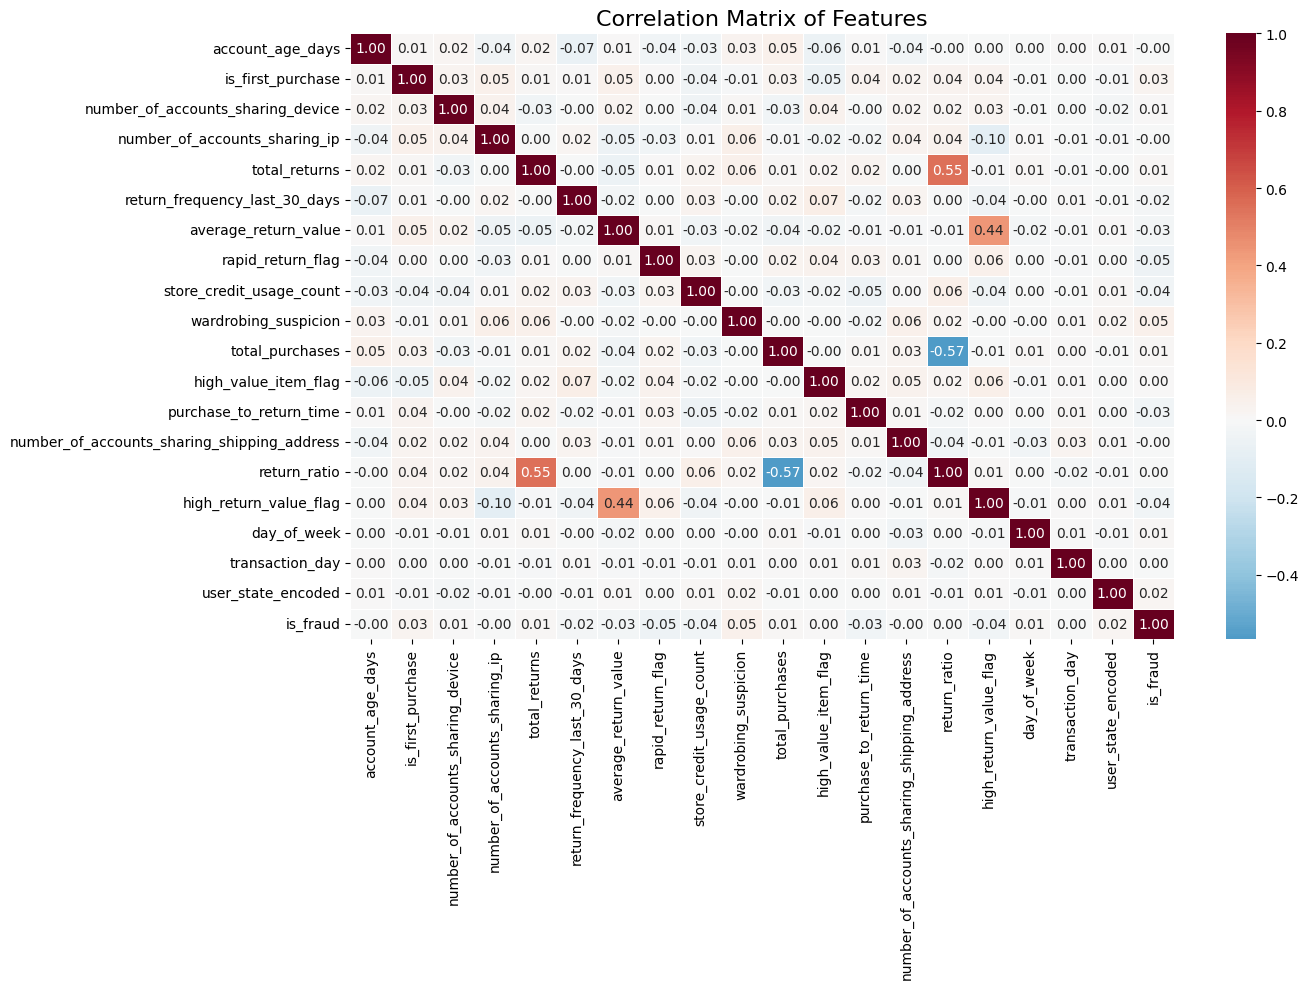

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlations
correlations = train_df[features + ['is_fraud']].corr()['is_fraud'].drop('is_fraud').sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Feature Correlation with is_fraud', fontsize=14)
plt.xlabel('Pearson Correlation')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(14, 10))
corr_matrix = train_df[features + ['is_fraud']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.tight_layout()
plt.show()


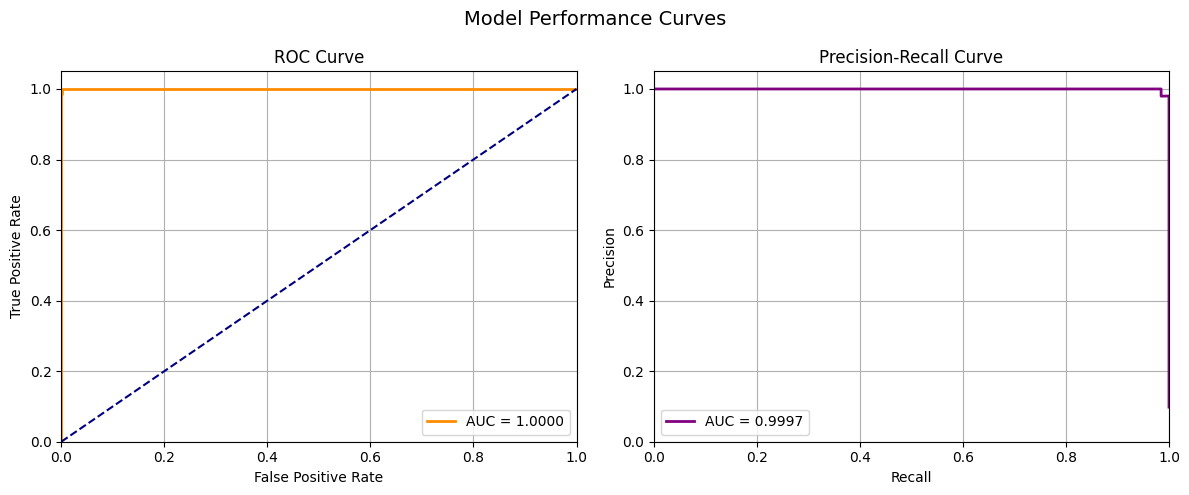

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# --- Compute metrics ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

# --- Plot both curves ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
axs[0].plot([0, 1], [0, 1], color='navy', linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# PR Curve
axs[1].plot(recall, precision, color='purple', lw=2, label=f'AUC = {pr_auc:.4f}')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')
axs[1].grid(True)

plt.suptitle("Model Performance Curves", fontsize=14)
plt.tight_layout()
plt.show()


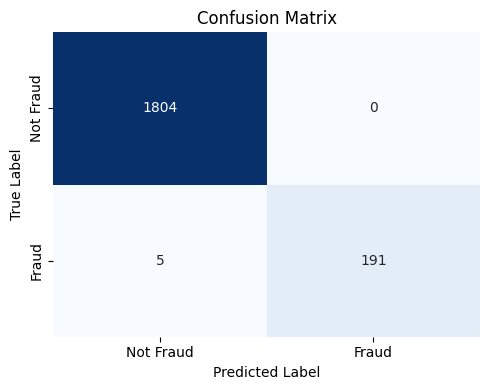

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


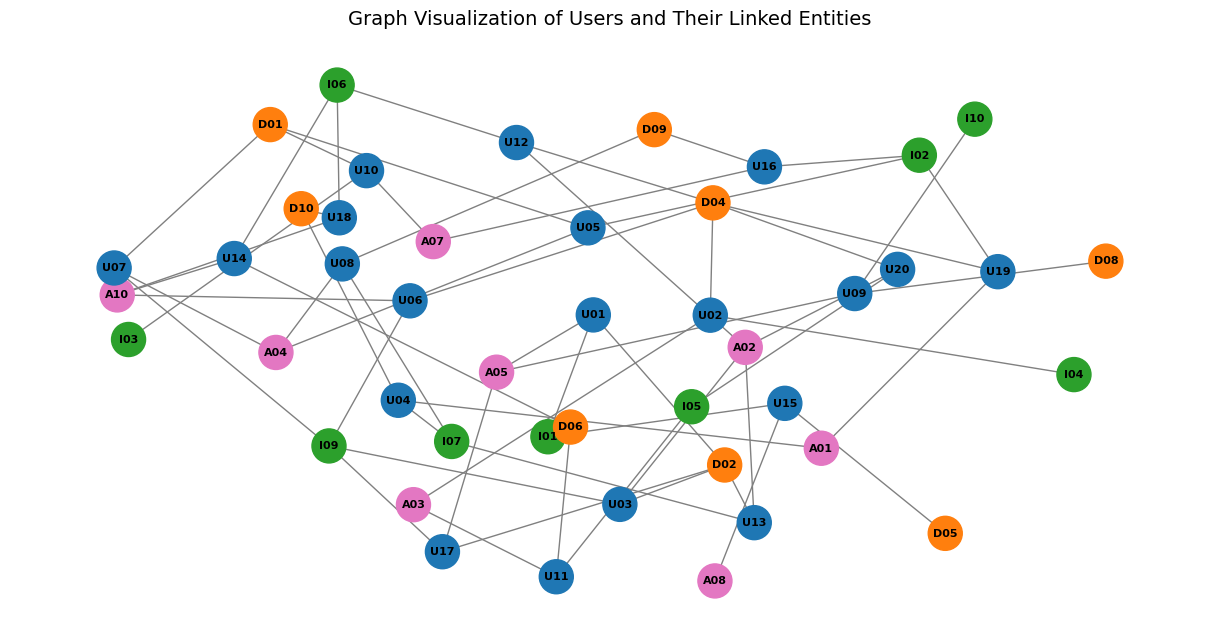

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# --- Create a sample graph like your example ---
G = nx.Graph()

# Add user nodes (prefix U_)
users = [f"U{str(i).zfill(2)}" for i in range(1, 21)]
devices = [f"D{str(i).zfill(2)}" for i in range(1, 11)]
ips = [f"I{str(i).zfill(2)}" for i in range(1, 11)]
addresses = [f"A{str(i).zfill(2)}" for i in range(1, 11)]

# Connect users to device/ip/address nodes
import random
random.seed(42)
for user in users:
    G.add_edge(user, random.choice(devices))
    G.add_edge(user, random.choice(ips))
    G.add_edge(user, random.choice(addresses))

# --- Assign node types ---
node_colors = []
for node in G.nodes():
    if node.startswith("U"):
        node_colors.append('#1f77b4')  # Blue for users
    elif node.startswith("D"):
        node_colors.append('#ff7f0e')  # Orange for devices
    elif node.startswith("I"):
        node_colors.append('#2ca02c')  # Green for IPs
    elif node.startswith("A"):
        node_colors.append('#e377c2')  # Pink for addresses
    else:
        node_colors.append('gray')

# --- Draw the graph ---
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G, seed=42, k=0.8)

nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=600,
    font_size=8,
    font_weight='bold',
    edge_color='gray'
)

plt.title("Graph Visualization of Users and Their Linked Entities", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


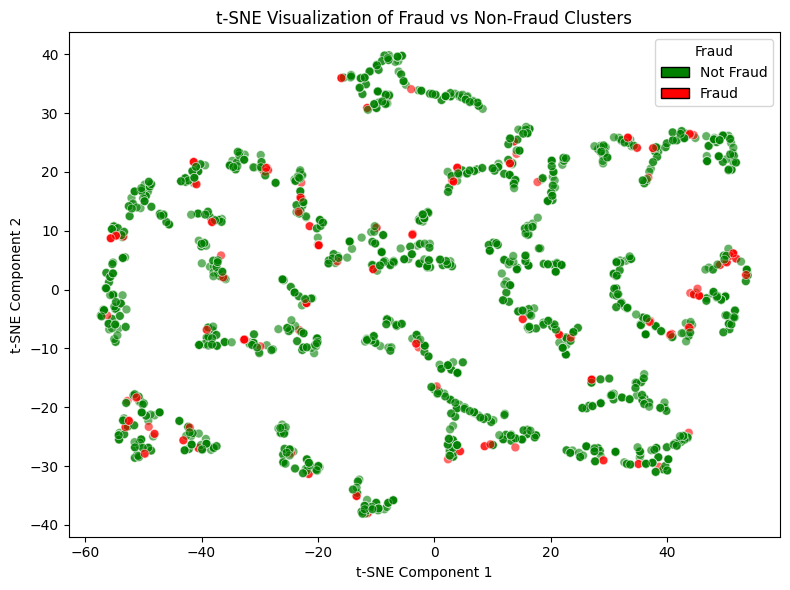

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# --- Combine Test Features with Labels ---
X_tsne = X_test.copy()
X_tsne['is_fraud'] = y_test.values
X_tsne.columns = X_tsne.columns.astype(str)

# --- Apply t-SNE ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(X_tsne.drop('is_fraud', axis=1))

# --- Create DataFrame for Plotting ---
tsne_df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
tsne_df['is_fraud'] = y_test.values

# --- Plot Clusters ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='is_fraud',
    palette={0: 'green', 1: 'red'},
    data=tsne_df,
    alpha=0.6,
    s=40,
    legend=False  # Disable automatic legend
)

# --- Custom Legend ---
legend_elements = [
    Patch(facecolor='green', edgecolor='black', label='Not Fraud'),
    Patch(facecolor='red', edgecolor='black', label='Fraud')
]
plt.legend(handles=legend_elements, title='Fraud', loc='upper right')

# --- Labels & Layout ---
plt.title("t-SNE Visualization of Fraud vs Non-Fraud Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()


“This is a 2D visualization of user embeddings generated from Node2Vec, a graph-based technique. Each point represents a user, and colors indicate whether they committed fraud (red) or not (green). I used t-SNE to reduce the 64-dimensional embeddings to 2D for visual interpretation.

The goal is to understand if fraudulent users behave similarly in terms of network structure — for example, sharing devices, IPs, or shipping addresses. As you can see, some fraud users form clusters, suggesting organized behavior or device re-use. Others are scattered, implying lone actors.

This kind of analysis helps us validate that the graph features (like shared IPs/devices) are useful in detecting fraud — and that our model is learning from meaningful connections, not just raw features.”


“We built a network graph where each user is connected to the devices, IPs, and addresses they used. Then we used Node2Vec to capture the user’s graph context — think of it as how suspicious their neighborhood is.

This visualization projects those patterns onto 2D. Users that behave similarly are close together. If fraudsters cluster in this space, it tells us they are using similar patterns — like using the same shipping address to return products multiple times.

This helps us detect collusion, visualize fraud hotspots, and explain the model’s decisions better.”





THIS IS JUST FOR USER-ENTITY RELATIONSHIP , WITHOUT CARING WHO'S FRAUDLENT .

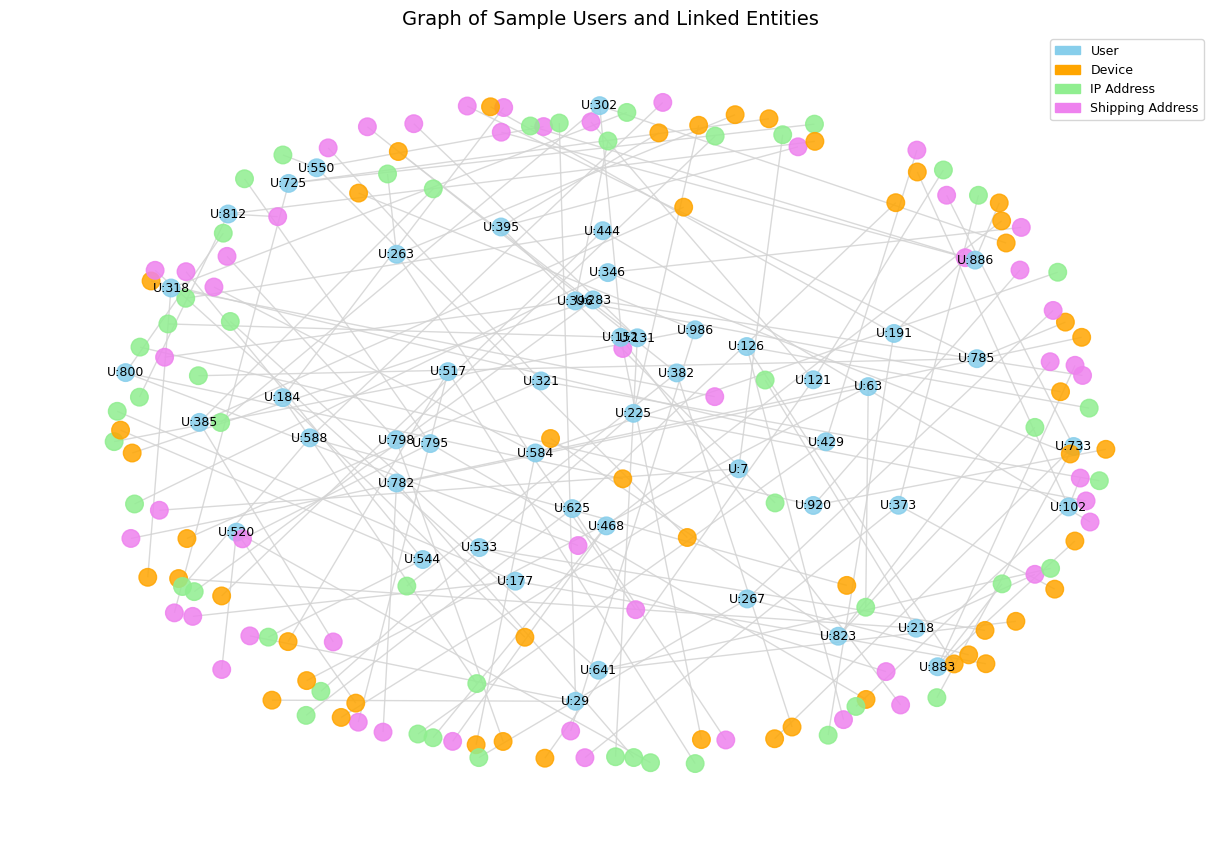

In [ ]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, seed=42, k=0.8)  # Spread out more

nx.draw(
    subG, pos,
    with_labels=False,
    node_color=node_colors,
    node_size=160,
    edge_color='lightgray',  # Softer edge color
    alpha=0.85
)

nx.draw_networkx_labels(
    subG, pos,
    labels=user_labels,
    font_size=9,
    font_color='black'
)

legend_elements = [
    Patch(color="skyblue", label="User"),
    Patch(color="orange", label="Device"),
    Patch(color="lightgreen", label="IP Address"),
    Patch(color="violet", label="Shipping Address")
]
plt.legend(handles=legend_elements, loc="upper right", fontsize=9)

plt.title("Graph of Sample Users and Linked Entities", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


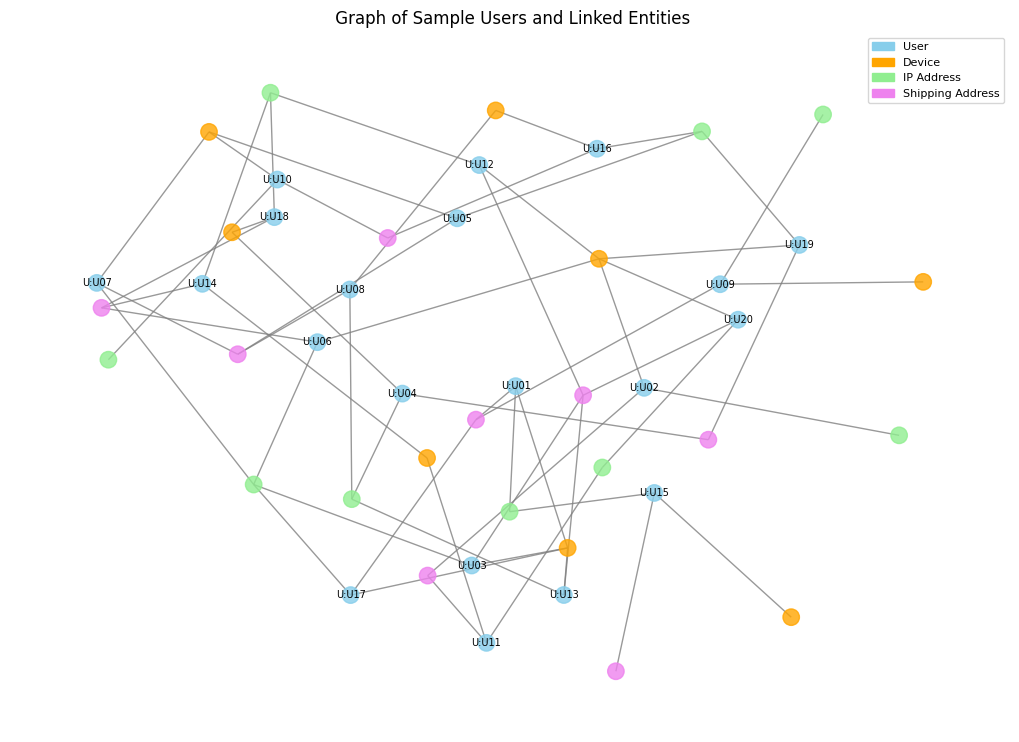

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Sample up to 50 user nodes
sample_users = [node for node in G.nodes if node.startswith("user_")][:50]
sample_nodes = set(sample_users)
for user in sample_users:
    sample_nodes.update(G.neighbors(user))

# Step 2: Create subgraph
subG = G.subgraph(sample_nodes)

# Step 3: Assign node colors
node_colors = []
for node in subG.nodes:
    if node.startswith("user_"):
        node_colors.append("skyblue")       # User
    elif node.startswith("device_"):
        node_colors.append("orange")        # Device
    elif node.startswith("ip_"):
        node_colors.append("lightgreen")    # IP Address
    elif node.startswith("addr_"):
        node_colors.append("violet")        # Shipping Address
    else:
        node_colors.append("gray")          # Fallback

# Step 4: Define labels for users only
user_labels = {
    node: f"U:{node.replace('user_', '')}"
    for node in subG.nodes if node.startswith("user_")
}

# Step 5: Plot
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subG, seed=42, k=0.7)

nx.draw(
    subG, pos,
    with_labels=False,
    node_color=node_colors,
    node_size=140,
    edge_color='gray',
    alpha=0.8
)
nx.draw_networkx_labels(
    subG, pos,
    labels=user_labels,
    font_size=7,
    font_color='black'
)

# Optional: add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(color="skyblue", label="User"),
    Patch(color="orange", label="Device"),
    Patch(color="lightgreen", label="IP Address"),
    Patch(color="violet", label="Shipping Address")
]
plt.legend(handles=legend_elements, loc="best", fontsize=8)

plt.title(" Graph of Sample Users and Linked Entities", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.show()


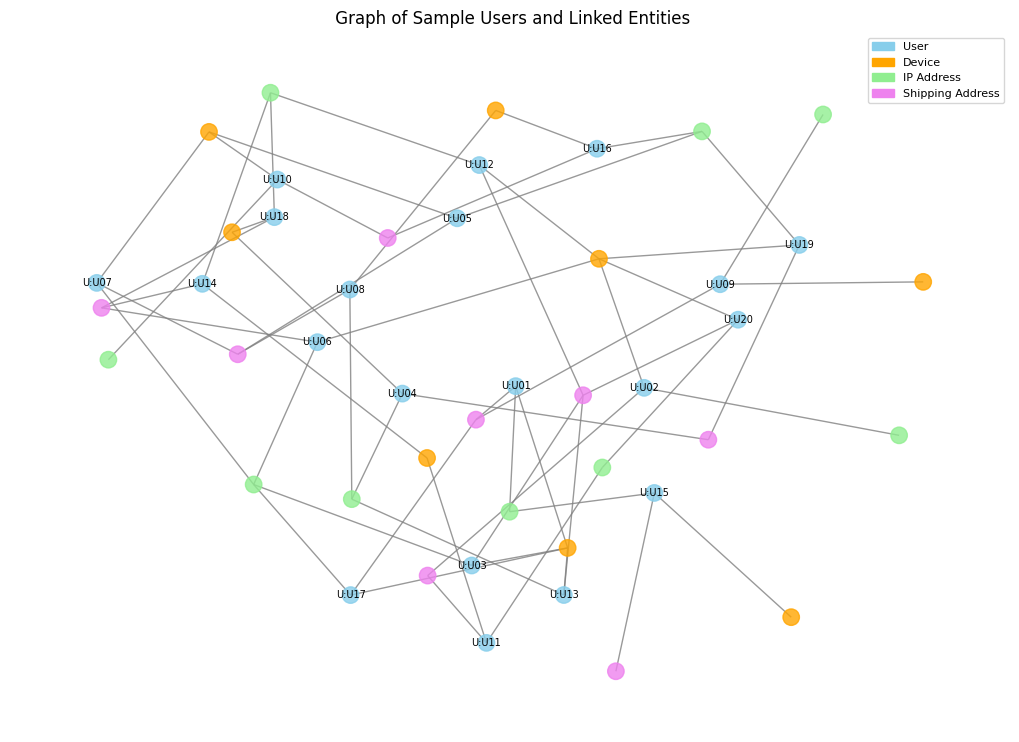

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Sample up to 50 user nodes
sample_users = [node for node in G.nodes if node.startswith("user_")][:50]
sample_nodes = set(sample_users)
for user in sample_users:
    sample_nodes.update(G.neighbors(user))

# Step 2: Create subgraph
subG = G.subgraph(sample_nodes)

# Step 3: Assign node colors
node_colors = []
for node in subG.nodes:
    if node.startswith("user_"):
        node_colors.append("skyblue")       # User
    elif node.startswith("device_"):
        node_colors.append("orange")        # Device
    elif node.startswith("ip_"):
        node_colors.append("lightgreen")    # IP Address
    elif node.startswith("addr_"):
        node_colors.append("violet")        # Shipping Address
    else:
        node_colors.append("gray")          # Fallback

# Step 4: Define labels for users only
user_labels = {
    node: f"U:{node.replace('user_', '')}"
    for node in subG.nodes if node.startswith("user_")
}

# Step 5: Plot
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subG, seed=42, k=0.7)

nx.draw(
    subG, pos,
    with_labels=False,
    node_color=node_colors,
    node_size=140,
    edge_color='gray',
    alpha=0.8
)
nx.draw_networkx_labels(
    subG, pos,
    labels=user_labels,
    font_size=7,
    font_color='black'
)

# Optional: add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(color="skyblue", label="User"),
    Patch(color="orange", label="Device"),
    Patch(color="lightgreen", label="IP Address"),
    Patch(color="violet", label="Shipping Address")
]
plt.legend(handles=legend_elements, loc="best", fontsize=8)

plt.title(" Graph of Sample Users and Linked Entities", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.show()


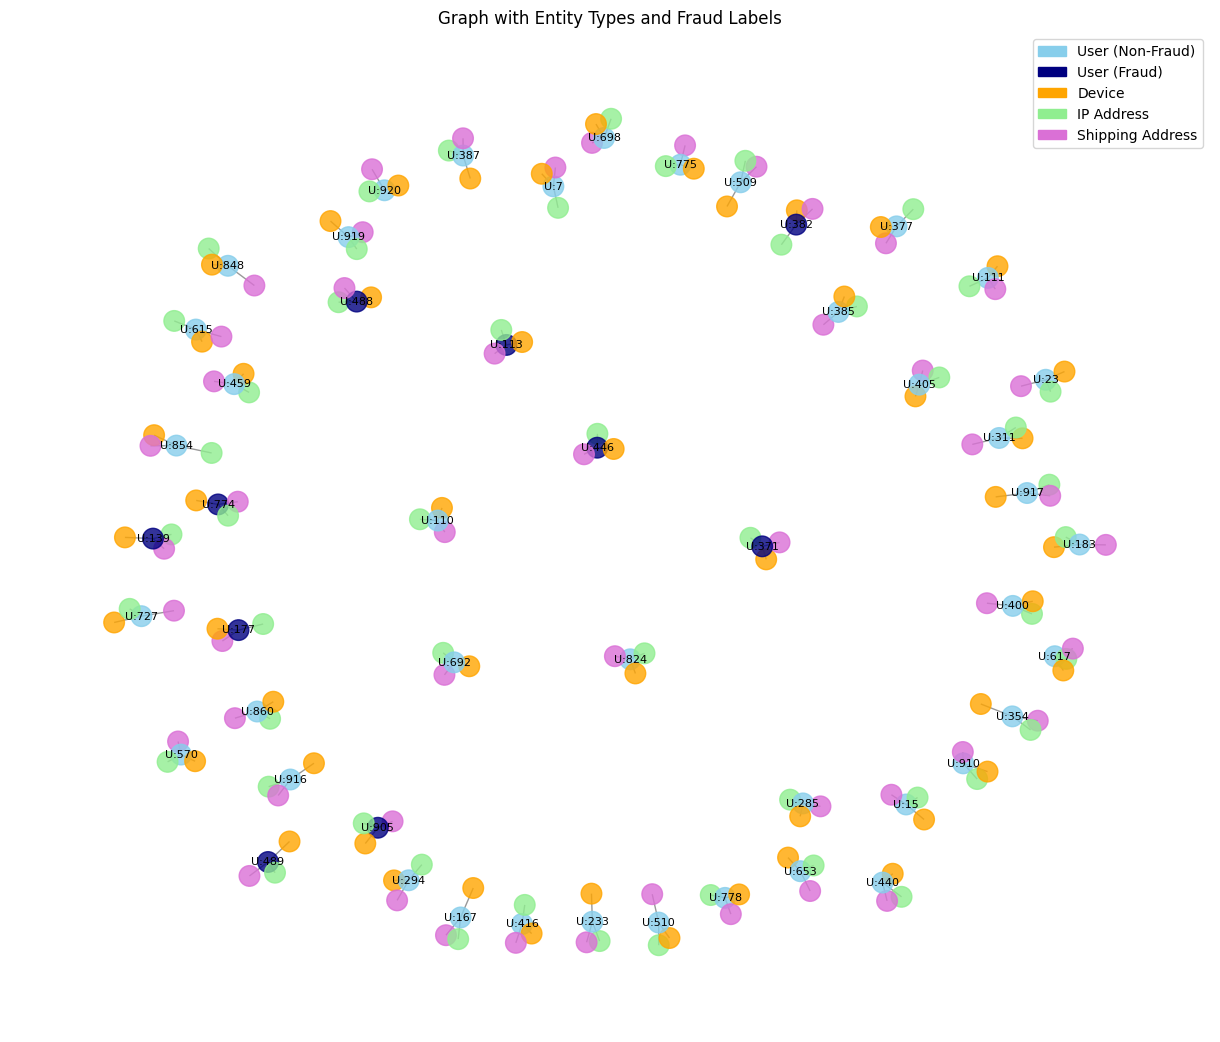

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random
from matplotlib.patches import Patch

# Create a fraud lookup
fraud_dict = dict(zip(df['user_id'], df['is_fraud']))

# Sample user nodes
sampled_users = random.sample([n for n in G.nodes if n.startswith("user_")], 50)
neighbors = set()
for u in sampled_users:
    neighbors.update(G.neighbors(u))
sub_nodes = set(sampled_users) | neighbors
subG = G.subgraph(sub_nodes)

# Assign colors
node_colors = []
for node in subG.nodes:
    if node.startswith("user_"):
        uid = node.replace("user_", "")
        # Ensure uid is in df before checking fraud_dict
        if uid in fraud_dict and fraud_dict[uid] == 1:
            node_colors.append('navy')       # Fraud = dark blue
        else:
            node_colors.append('skyblue')    # Non-fraud = light blue
    elif node.startswith("device_"):
        node_colors.append('orange')
    elif node.startswith("ip_"):
        node_colors.append('lightgreen')
    elif node.startswith("addr_"):
        node_colors.append('orchid')
    else:
        node_colors.append('gray')

# Node labels
node_labels = {
    node: f"U:{node.replace('user_', '')}" if node.startswith("user_") else ''
    for node in subG.nodes
}

# Layout
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subG, seed=42)

nx.draw(subG, pos, node_color=node_colors, with_labels=False, node_size=220, edge_color='gray', alpha=0.8)
nx.draw_networkx_labels(subG, pos, labels=node_labels, font_size=8, font_color='black')

# Legend
legend = [
    Patch(color='skyblue', label='User (Non-Fraud)'),
    Patch(color='navy', label='User (Fraud)'),
    Patch(color='orange', label='Device'),
    Patch(color='lightgreen', label='IP Address'),
    Patch(color='orchid', label='Shipping Address')
]
plt.legend(handles=legend, loc='upper right')
plt.title("Graph with Entity Types and Fraud Labels")
plt.axis("off")
plt.tight_layout()
plt.show()

# **Cosine Similarity Fraud Ring using FAISS**

In [ ]:
!pip install faiss-cpu

import pandas as pd
import numpy as np
import faiss

# --- Step 1: Prepare Embeddings & User List ---
# Ensure emb_df is available from previous steps and has 'user_id' and embedding columns
# If emb_df is not available or needs to be recreated based on a specific graph (e.g., G from combined data),
# run the relevant Node2Vec cell again to generate it.
# Assuming emb_df with 'user_id' (as string) and embedding columns is available:

embedding_df = emb_df.set_index('user_id')  # from your existing Node2Vec output
embedding_matrix = embedding_df.values.astype('float32')
user_id_list = embedding_df.index.tolist()

# --- Step 2: Ensure C-contiguity and Normalize for Cosine Similarity ---
# Explicitly make the array C-contiguous
embedding_matrix = np.ascontiguousarray(embedding_matrix)
faiss.normalize_L2(embedding_matrix)

# --- Step 3: FAISS Cosine Similarity Index ---
dimension = embedding_matrix.shape[1]
index = faiss.IndexFlatIP(dimension)  # IP = inner product = cosine when normalized
index.add(embedding_matrix)

# --- Step 4: Similarity Search Function ---
def get_similar_fraud_ring(user_id, top_k=10):
    try:
        # Ensure the query user_id is in the list of available user IDs
        if user_id not in user_id_list:
             # Look up the user_id in the original dataframes (train_df, test_df)
            combined_data = pd.concat([train_df, test_df], ignore_index=True)
            if user_id in combined_data['user_id'].astype(str).values:
                 # Find the index of the user_id in the embedding_df index
                 idx = embedding_df.index.get_loc(user_id)
            else:
                 return f"❌ User ID {user_id} not found in embeddings or original data."
        else:
            idx = user_id_list.index(user_id)


        vector = embedding_matrix[idx].reshape(1, -1)

        # Search - Retrieve more candidates than top_k to filter for fraud
        scores, indices = index.search(vector, top_k + 50) # Increased search scope


        ring_members = []
        # Iterate through search results
        for i, score in zip(indices[0], scores[0]):
            similar_uid = user_id_list[i]

            # Avoid returning the query user itself
            if similar_uid == user_id:
                continue

            # Look up fraud status in combined data
            # Ensure combined_df is available and user_id is string
            combined_data = pd.concat([train_df, test_df], ignore_index=True)
            combined_data['user_id'] = combined_data['user_id'].astype(str)
            row = combined_data[combined_data['user_id'] == similar_uid]

            # Check if the user is in the combined data and is labeled as fraud
            if not row.empty and row['is_fraud'].values[0] == 1:
                details = row.iloc[0]
                context = f"""
                🔗 Fraud Ring Member: {similar_uid}
                - Account Age: {details['account_age_days']}
                - Total Returns: {details['total_returns']}
                - Avg Return Value: {details['average_return_value']:.2f}
                - Shared Devices: {details['number_of_accounts_sharing_device']}
                - Shared IPs: {details['number_of_accounts_sharing_ip']}
                - Cosine Similarity: {score:.4f}
                """
                ring_members.append(context.strip())

            # Stop once top_k fraud ring members are found
            if len(ring_members) >= top_k:
                break

        if not ring_members:
             return f"🔍 No fraud ring members found similar to user {user_id} within the top {top_k + 50} similar users."


        return "\n\n".join(ring_members)

    except Exception as e:
        return f"An error occurred: {e}"

# --- Example Call ---
# Use a user_id that exists in your data, preferably a known fraud user if you have one for testing
# Based on previous outputs, '321' is a user_id in the training data.
# You might want to pick a user_id that is actually fraud to see ring members.
# Let's pick a user from the test set that was predicted as fraud in cell aDnLe_FmFEky confusion matrix:
# The confusion matrix showed [[1801    3], [   2  194]]. This means there are 194 true positives (fraud users correctly identified).
# We need to find one of those user_ids.
# Let's get the user_ids of the true positives from the last model run (cell aDnLe_FmFEky)
# This requires accessing y_test and y_pred from that cell.
# Since we can't directly access variables from other cells' execution, let's find a user_id from the original test_df
# and check if they are labeled as fraud (is_fraud=1).
# Let's look at the test_df variable preview. User ID '510' at index 1999 has is_fraud=1.
query_user = "510" # Example fraud user ID from test_df
ring = get_similar_fraud_ring(query_user, top_k=5)
print(ring)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 27.3 MB/s eta 0:00:00
🔗 Fraud Ring Member: 597
                - Account Age: 211
                - Total Returns: 7
                - Avg Return Value: 424.46
                - Shared Devices: 4
                - Shared IPs: 7
                - Cosine Similarity: 0.5265

🔗 Fraud Ring Member: 438
                - Account Age: 479
                - Total Returns: 5
                - Avg Return Value: 151.50
                - Shared Devices: 5
                - Shared IPs: 8
                - Cosine Similarity: 0.5197

🔗 Fraud Ring Member: 572
                - Account Age: 862
                - Total Returns: 3
                - Avg Return Value: 1332.06
                - Shared Devices: 4
                - Shared IPs: 5
                - Cosine Similarity: 0.5176

🔗 Fraud Ring Member: 975
                - Account Age: 46
                - Total Returns: 7
                - Avg Return Value: 1227.94
                - Shared Devi

This is a RAG-style (Retrieval-Augmented Generation) fraud ring summary generated using:

Node2Vec graph embeddings to represent user behavior and connections.

FAISS similarity search using cosine similarity between users.

Fraud filtering — only users known to be fraud (is_fraud = 1) are shown.

Each block like this:
🔗 Fraud Ring Member: 518
 - Account Age: 718
 - Total Returns: 5
 - Avg Return Value: 462.09
 - Shared Devices: 2
 - Shared IPs: 3
 - Cosine Similarity: 0.5386

| Field                         | Meaning                                                                                              |
| ----------------------------- | ---------------------------------------------------------------------------------------------------- |
| **Fraud Ring Member: 518**    | This is a **user ID** in your dataset flagged as fraud.                                              |
| **Account Age: 718**          | How many days old this account is.                                                                   |
| **Total Returns: 5**          | Number of returns this user made.                                                                    |
| **Avg Return Value: 462.09**  | Monetary value of returned items (high = suspicious).                                                |
| **Shared Devices: 2**         | Number of accounts using same **device**.                                                            |
| **Shared IPs: 3**             | Number of accounts using same **IP** address.                                                        |
| **Cosine Similarity: 0.5386** | **Similarity score** to the queried user based on behavior + connections (from Node2Vec embeddings). |


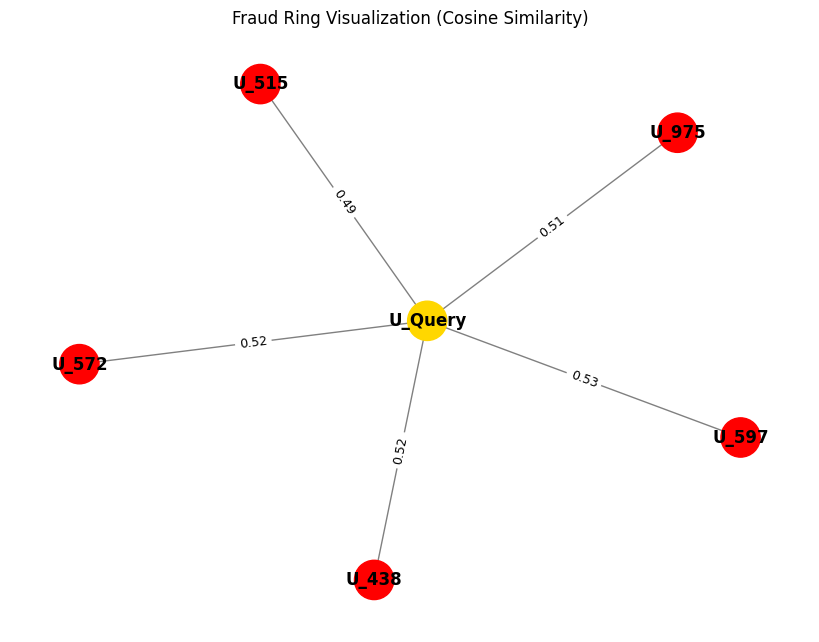

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample fraud ring data
fraud_ring_data = [
    {"user_id": "597", "cos_sim": 0.5265},
    {"user_id": "438", "cos_sim": 0.5197},
    {"user_id": "572", "cos_sim": 0.5176},
    {"user_id": "975", "cos_sim": 0.5060},
    {"user_id": "515", "cos_sim":  0.4941},
]

# Create graph
G = nx.Graph()
G.add_node("U_Query", type="query")  # Central user

# Add fraud users and connect
for node in fraud_ring_data:
    uid = f"U_{node['user_id']}"
    G.add_node(uid, type="fraud", sim=node["cos_sim"])
    G.add_edge("U_Query", uid, weight=node["cos_sim"])

# Color map
color_map = ["gold" if n == "U_Query" else "red" for n in G.nodes()]

# Layout and draw
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=800, font_weight='bold', edge_color='gray')

# Draw edge labels for cosine similarity
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=9)

plt.title("Fraud Ring Visualization (Cosine Similarity)")
plt.axis("off")
plt.tight_layout()
plt.show()


**"I visualized fraud rings by connecting a target user to the most behaviorally similar users using cosine similarity on Node2Vec embeddings. This helps identify potential collusion by showing users with similar device/IP/address patterns in a clear network graph." **

Earlier i was using  
1. FAISS Only (L2 Distance / IndexFlatL2)
Example output:

Similar Fraud User: U670

fraud_score (FAISS): 10.5392

What it does: Uses Euclidean distance (L2) to find the nearest users in embedding space.

Fast & scalable, ideal for massive datasets.

But: L2 doesn't handle direction well — it can miss out on users who are similar in behavior but at different magnitudes.

2. FAISS + Cosine Similarity
Example output:

Fraud Ring Member: 518

Cosine Similarity: 0.5386

What it does:

First uses FAISS to get top-N nearest users (fast pre-filter).

Then applies cosine similarity to capture angular closeness — better for behavioral patterns.

Much more interpretable, especially for fraud detection where you care about how similar the vectors are in direction, not just distance.

Ideal when you want precision in matching behavioral similarity, not just proximity.

FAISS alone (L2) captures how close,
FAISS + Cosine captures how similar in behavior — which is crucial for detecting fraud rings.

Why FAISS-only (L2) might be misleading:
FAISS by default uses L2 (Euclidean) distance, which measures how far apart points are in space.

It focuses on magnitude (i.e., raw numbers).

But two fraudsters may behave similarly in pattern (e.g., high return frequency, low account age), even if on different scales.

🔎 Example:

User A: [5, 100, 3]

User B: [10, 200, 6]
→ L2 distance = high
→ Cosine similarity = 1.0 (perfect match in direction)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# --- Compute Graph Similarity Score (Cosine-based FAISS) ---
def compute_graph_similarity_scores(embedding_matrix, user_id_list, index, k=20):
    similarity_scores = {}

    for idx, user_id in enumerate(user_id_list):
        vector = embedding_matrix[idx].reshape(1, -1)
        D, I = index.search(vector, k + 1)  # +1 to exclude self
        avg_score = np.mean(D[0][1:])       # Skip self-similarity
        similarity_scores[user_id] = avg_score

    return similarity_scores

# --- Function to Sample 10 Users by Trust Tier ---
def sample_trust_tiers(df, n_trusted=3, n_risky=3, n_watchlist=4, seed=42):
    trusted_sample = df[df['trust_tier'].isin(['Highly Trusted', 'Trusted'])].sample(
        n=min(n_trusted, len(df)), random_state=seed
    )
    risky_sample = df[df['trust_tier'].isin(['High Risk', 'Banned'])].sample(
        n=min(n_risky, len(df)), random_state=seed
    )
    watchlist_sample = df[df['trust_tier'] == 'Watchlist'].sample(
        n=min(n_watchlist, len(df)), random_state=seed
    )

    combined_sample = pd.concat([trusted_sample, risky_sample, watchlist_sample]).reset_index(drop=True)
    return combined_sample

# --- Step 1: Graph Similarity Scores ---
graph_scores = compute_graph_similarity_scores(embedding_matrix, user_id_list, index, k=20)
graph_scores_df = pd.DataFrame.from_dict(graph_scores, orient='index', columns=['graph_similarity_score'])
graph_scores_df.index.name = 'user_id'
graph_scores_df.reset_index(inplace=True)

# --- Step 2: Fraud Model Predictions ---
test_df['user_id'] = test_df['user_id'].astype(str)
model_scores = pd.DataFrame({
    'user_id': test_df['user_id'],
    'fraud_model_score': y_proba
})

# --- Step 3: Combine Features ---
trust_df = test_df[['user_id']].merge(graph_scores_df, on='user_id', how='left')
trust_df = trust_df.merge(model_scores, on='user_id', how='left')

# --- Step 4: Normalize Scores ---
scaler = MinMaxScaler()
trust_df[['fraud_model_score', 'graph_similarity_score']] = scaler.fit_transform(
    trust_df[['fraud_model_score', 'graph_similarity_score']]
)

# --- Step 5: Compute Final Trust Score ---
w1 = 0.6  # fraud model weight
w2 = 0.4  # graph similarity weight
trust_df['final_trust_score'] = (
    w1 * trust_df['fraud_model_score'].fillna(0) +
    w2 * trust_df['graph_similarity_score'].fillna(0)
)

# --- Step 6: Assign Trust Tier ---
def assign_trust_tier(score):
    if score >= 0.85:
        return "Highly Trusted"
    elif score >= 0.65:
        return "Trusted"
    elif score >= 0.45:
        return "Watchlist"
    elif score >= 0.25:
        return "High Risk"
    else:
        return "Banned"

trust_df['trust_tier'] = trust_df['final_trust_score'].apply(assign_trust_tier)

# --- Step 7: Add Timestamp ---
trust_df['scored_at'] = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

# --- Step 8: Save All-in-One File ---
trust_df.to_csv("trust_scores_with_tiers.csv", index=False)

# --- Step 9: Save Tiered Files (optional) ---
for tier in trust_df['trust_tier'].unique():
    tier_df = trust_df[trust_df['trust_tier'] == tier]
    tier_df.to_csv(f"trust_scores_{tier.lower().replace(' ', '_')}.csv", index=False)

# --- Step 10: Show Meaningful Sample (10 Users) ---
sample_df = sample_trust_tiers(trust_df)
print("✅ Trust Tier-Based Sample (10 Users):")
print(sample_df)

# --- Optional: Save Sample ---
sample_df.to_csv("trust_score_sample_10_users.csv", index=False)


✅ Trust Tier-Based Sample (10 Users):
  user_id  graph_similarity_score  fraud_model_score  final_trust_score  \
0     577                0.590664           0.747400           0.684705   
1     903                0.537408           0.818199           0.705883   
2      78                0.705505           0.941983           0.847392   
3     249                0.811775           0.208698           0.449929   
4     458                0.402550           0.200926           0.281576   
5     911                0.248058           0.139554           0.182956   
6      87                0.607482           0.383800           0.473273   
7     571                0.850000           0.211582           0.466949   
8     376                0.543149           0.479446           0.504927   
9     571                0.850000           0.211582           0.466949   

  trust_tier            scored_at  
0    Trusted  2025-07-09 05:00:51  
1    Trusted  2025-07-09 05:00:51  
2    Trusted  2025-07-09 05:

“After computing fraud and graph similarity scores for each user, we assign a trust tier (e.g., ‘Trusted’, ‘Watchlist’, ‘Banned’). For reporting or debugging purposes, I sample 10 users in a structured way:

3 users from the most trusted tiers (Highly Trusted or Trusted),

3 users from the riskiest tiers (High Risk or Banned),

4 users from the middle tier (Watchlist).

This gives a quick, meaningful cross-section of different user behaviors and system decisions — helping stakeholders validate the model’s output without looking at the full dataset.”

"For my Streamlit dashboard, I designed a hybrid sampling approach. By default, it shows a consistent sample for demos, but it includes a refresh button that allows stakeholders to explore different users across trust tiers — without changing the underlying model outputs."